In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time

from libworm.model.beta_neuron import NeuronNetwork, from_connectome
from libworm.data import connectomes, traces
from libworm import preprocess
from libworm.functions import set_neurons, tcalc_s_inf, set_trace
from libworm.data.neuron import full_sensory_list

import json

from math import tau

In [5]:
trace.shape

(1600, 98)

In [4]:
_, trace, trace_labels, label2index, timestamps = traces.load_trace()
timestamps = timestamps - timestamps[0]

chemical, gapjn = connectomes.load_cook_connectome()
neurons = connectomes.get_main_neurons(chemical, gapjn)
neurons.sort(key=lambda item: f"AAA{label2index[item]:04d}{item}" if item in label2index else item)

not_in_main_section = [label2index[key] for key in label2index if key not in neurons]
not_labelled = [i for i, _ in enumerate(trace[:, 0]) if i not in label2index.values()]

removal = list(set(not_in_main_section).union(not_labelled))

trace = np.delete(trace, removal, axis=0).T

In [3]:
def get_notable(arr):
    # Create a list of tuples containing (element, index)
    indexed_arr = [(elem, idx) for idx, elem in enumerate(arr)]
    
    # Sort the indexed array based on element values
    sorted_arr = sorted(indexed_arr, key=lambda x: x[0])
    
    # Get the indices of the 5 lowest elements
    lowest_indices = [idx for _, idx in sorted_arr[:5]]
    
    # Get the indices of the 5 highest elements
    highest_indices = [idx for _, idx in sorted_arr[-5:]]
    
    return lowest_indices, highest_indices

In [4]:
def side_comp(datas, count = 32, per = 8, stride=1, ymin=-50, ymax=5, show_sens=True, start_offset=0):

    rows = int(np.ceil(count / per))

    fig, axs = plt.subplots(ncols=len(datas), nrows=rows, figsize=(5*9, 5*9))

    for ax in axs.flatten().tolist():
        ax.set_ylim([ymin, ymax])

    ax_index = -1
    
    # Voltage time curves
    for i in range(count):
        if i % per == 0:
            ax_index += 1
        
        for j, data in enumerate(datas): 
            if i in sensory_indices:
                if show_sens:
                    axs[ax_index, j].plot(data[::stride, i + start_offset], label=f'V_m_{i + start_offset}', marker='^')
                elif per == 1 and j == 0:
                    ax_index -= 1
            else:
                axs[ax_index, j].plot(data[::stride, i + start_offset], label=f'V_m_{i + start_offset}')
            

    for ax in axs.flatten().tolist():
        ax.legend(loc='best')
        
    plt.show()

In [21]:
len([i for i in sensory_indices if i <= 98])

41

In [22]:
98-41

57

In [5]:
sensory_indices = [neurons.index(cell) for cell in full_sensory_list]

def show_large_voltage_data(data, offset = None, count = None, per = 8.0, stride=1):

    if offset is None:
        pass
    else:
        data = data[offset:, :]
    
    if count is None:
        pass
    else:
        data = data[:, :count]

    size = int(np.ceil(np.sqrt(data.shape[1] / per)))

    fig, axs = plt.subplots(ncols=size, nrows=size, figsize=(5*7, 5*7))

    ax_index = -1
    
    # Voltage time curves
    for i in range(data.shape[1]):
        if i % per == 0:
            if ax_index >= 0:
                axs[ax_index // size, ax_index % size].legend(loc='best')
            ax_index += 1

        if i in sensory_indices:
            axs[ax_index // size, ax_index % size].plot(data[::stride, i], label=f'V_m_{i}', marker='^')
        else:
            axs[ax_index // size, ax_index % size].plot(data[::stride, i], label=f'V_m_{i}')
    
        
    
    plt.show()

# Average Predictor

In [15]:
timestamps[1500]

902.4033346150536

In [7]:
trace.shape

(1600, 98)

In [8]:
trace_avg = np.average(trace, axis=0)

total = 0
for i in range(98):
    if i in sensory_indices:
        continue
    sum = np.sum((trace[:500, i] - trace_avg[i]) ** 2)
    total += sum

print(total)

39501.885772998794


In [23]:
test_avg

340.6577636627806

In [29]:
np.max(just_evals / label_len)

16.47802769204266

In [25]:
with open("rust/results/full_test_run.json", "r") as file:
    test_run = np.array(json.load(file))

with open("rust/results/full_test_run_evals.json", "r") as file:
    test_evals = np.array(json.load(file))


just_evals = np.array([item for item in test_evals if item != 0.0])

label_len = 1496

print("Raw MSE")
print(np.average(just_evals / label_len))

test_avg = np.average([item for item in test_evals if item != 0.0])
zeros_removed = [test_avg if item == 0 else item for item in test_evals]
                    
mod_trace = 15 * trace[:500, :] - 10

timeline = np.linspace(0, 300.0, mod_trace.shape[0])
test_timeline = np.linspace(0, 300.0, test_run.shape[0])

print(get_notable(zeros_removed))

Raw MSE
11.07780870366034
([38, 95, 48, 41, 35], [63, 34, 68, 72, 10])


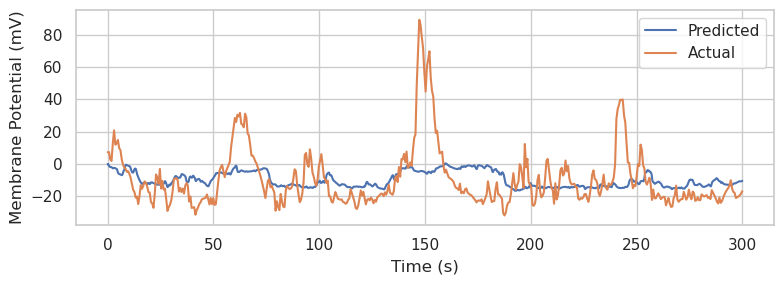

In [84]:
sns.set_theme(style="whitegrid")
plt.plot(test_timeline, test_run[:, 37], label="Predicted")
plt.plot(timeline, mod_trace[:, 37], label="Actual")
plt.legend(loc='best')

plt.xlabel("Time (s)")
plt.ylabel("Membrane Potential (mV)")

fig = plt.gcf()
fig.set_size_inches(8, 3)
plt.tight_layout()

#plt.savefig('img/third_worst_full_trained_n37.png', dpi=150)
plt.show()

# Numeric Type Stuff

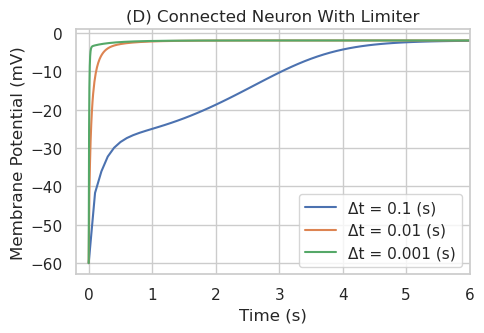

In [60]:
sns.set_theme(style="whitegrid")
with open("rust/final_results/numeric_run_high_timestepwith_limiter.json", "r") as file:
    high_time = np.array(json.load(file))

with open("rust/final_results/tmp_b.json", "r") as file:
    med_time = np.array(json.load(file))

with open("rust/final_results/numeric_run_with_limiter.json", "r") as file:
    low_time = np.array(json.load(file))

with open("rust/final_results/numeric_run_equil.json", "r") as file:
    ashr_equil = np.array(json.load(file))

ashr_diff = ashr_trace - ashr_equil

timeline = np.linspace(0, 8.0, high_time.shape[0])
timecurve = np.linspace(0, 8.0, med_time.shape[0])
alt_timeline = np.linspace(0, 8.0, low_time.shape[0])

plt.title("(D) Connected Neuron With Limiter")
plt.xlabel("Time (s)")
plt.ylabel("Membrane Potential (mV)")

fig = plt.gcf()
fig.set_size_inches(5, 3.5)
plt.tight_layout()

plt.xlim(-0.2, 6)

plt.plot(timeline, high_time[:, 0], label=f"Δt = 0.1 (s)")
plt.plot(timecurve, med_time[:, 0], label=f"Δt = 0.01 (s)")
plt.plot(alt_timeline, low_time[:, 0], label=f"Δt = 0.001 (s)")

plt.legend(loc='best')
#plt.savefig('img/full_numeric_with_limiter.png', dpi=150)

# ASHR type stuff

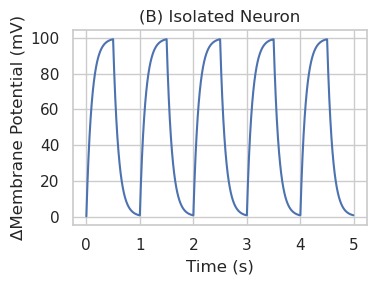

In [34]:
sns.set_theme(style="whitegrid")
with open("rust/final_results/disconnected_ashr.json", "r") as file:
    ashr_trace = np.array(json.load(file))

with open("rust/final_results/disconnected_ashr_equil.json", "r") as file:
    ashr_equil = np.array(json.load(file))

ashr_diff = ashr_trace - ashr_equil

timeline = np.linspace(0, 20.0, 2001)

plt.title("(B) Isolated Neuron")
plt.xlabel("Time (s)")
plt.ylabel("ΔMembrane Potential (mV)")

fig = plt.gcf()
fig.set_size_inches(4, 3)
plt.tight_layout()

plt.plot(timeline[:500], ashr_diff[:500, 128])
#plt.savefig('img/ashr_disconnected.png', dpi=150)

In [68]:
np.average(plm_data, axis=0).shape

(280,)

271


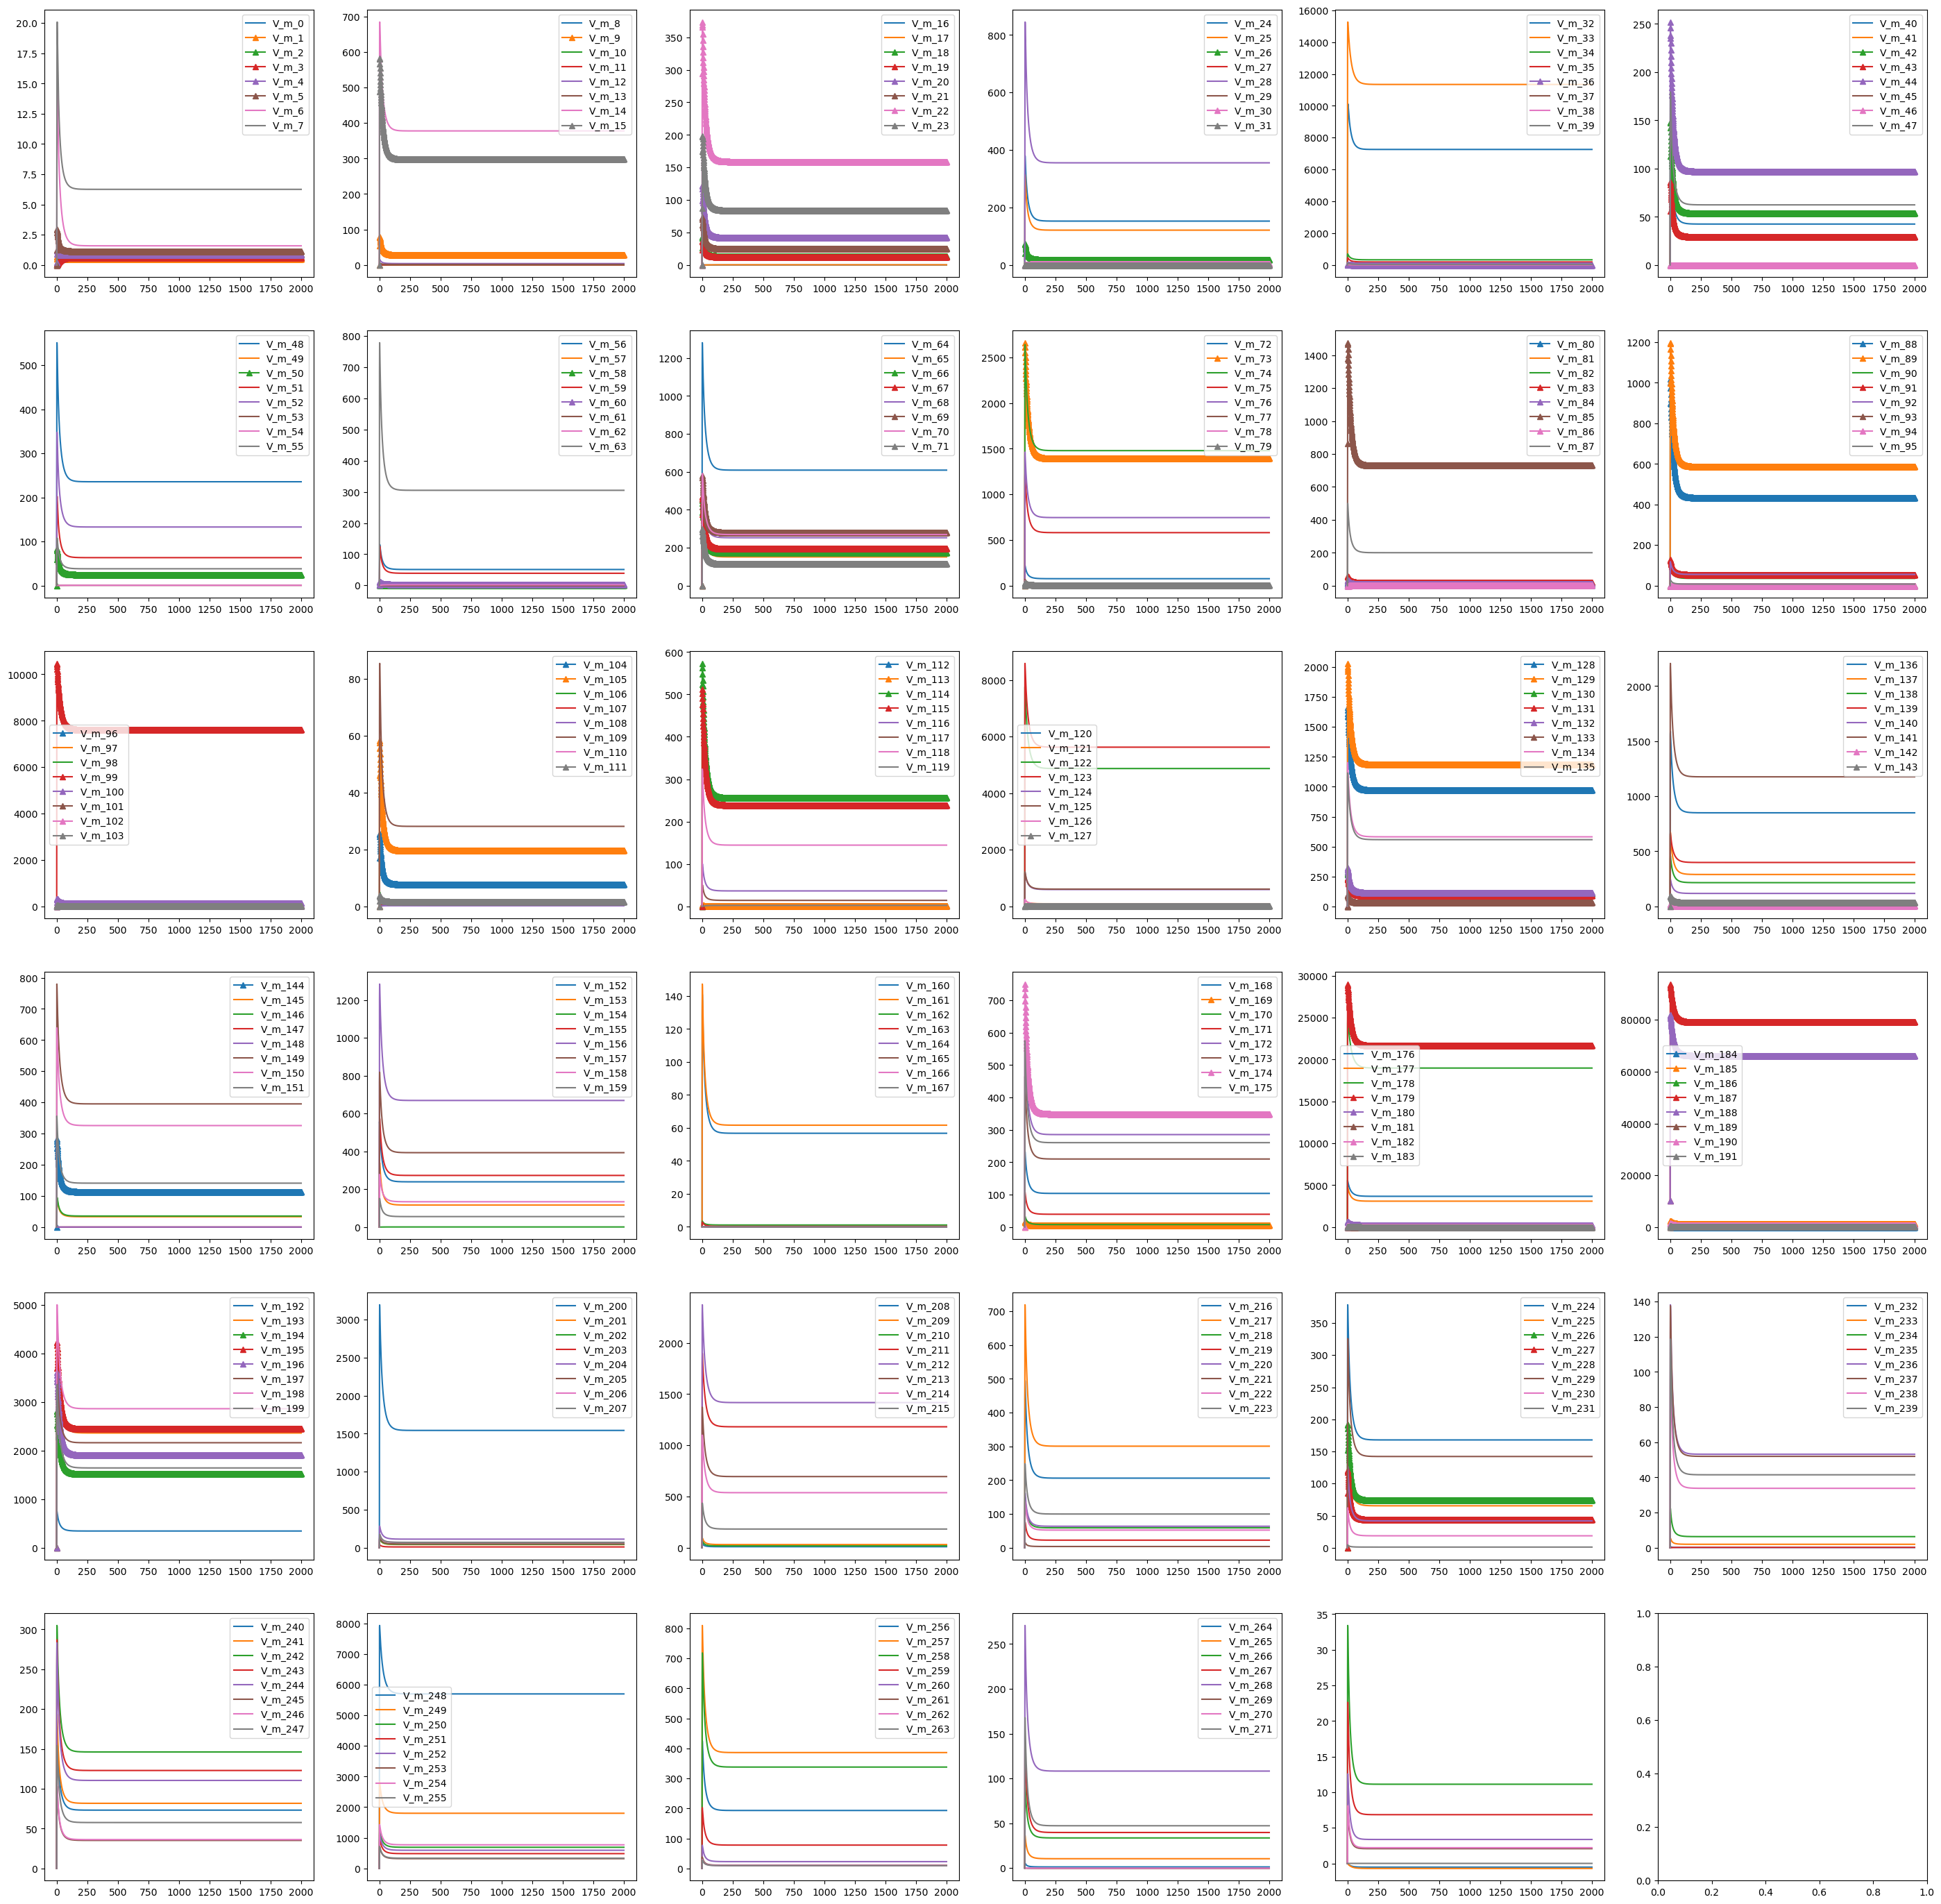

In [133]:
# prev_data = data

with open("rust/results/plm_test_run.json", "r") as file:
    plm_data = np.array(json.load(file))

with open("rust/results/con2_plm_test_run.json", "r") as file:
    ashr_data = np.array(json.load(file))

with open("rust/results/con2_plm_equil.json", "r") as file:
    rest_voltage = np.array(json.load(file))

mod_trace = 15.0 * trace.T[:500, :] - 10.0

#side_comp([plm_data, small_data], start_offset=185, per=2, count=10, ymax=150, show_sens=True)
norm_plm_data = plm_data - np.average(plm_data, axis=0)
norm_ashr_data = ashr_data - rest_voltage

#Remove low std
ashr_std = np.std(ashr_data, axis=0)
std_removal = [i for i in range(280) if norm_ashr_data[:, i].min() < -0.03 or norm_ashr_data[:, i].max() > 0.2]
print(len(std_removal))
ashr_filtered = np.delete(norm_ashr_data, std_removal, axis=1)

show_large_voltage_data(norm_ashr_data)

In [18]:
with open("rust/results/correct_trace_processing.json", "r") as file:
    data = np.array(json.load(file))

data = np.nan_to_num(data.astype(np.float64), nan=5000)

In [19]:
data[:, 2]

array([3471.14997217, 3470.43104891, 3469.73799232, ..., 5868.07335519,
       5897.66842077, 5927.43706143])

In [20]:
data[22487]

array([  12.        ,  -13.        , 3309.51896052])

In [21]:
data[:, 2].max()

9158471.555543434

In [22]:
data[:, 2].argmin()

22487

In [23]:
data[:, 2].min()

3309.518960516862

In [24]:
slice = data[:, 2].reshape(200, 200)
slice.shape

(200, 200)

In [25]:
slice

array([[3471.14997217, 3470.43104891, 3469.73799232, ..., 3543.78190493,
        3549.29582962, 3554.96383933],
       [3471.67667846, 3470.92892164, 3470.20874776, ..., 3549.75768227,
        3555.48774943, 3561.37590846],
       [3472.2325648 , 3471.45433303, 3470.70529211, ..., 3556.0226594 ,
        3561.97763366, 3568.09488167],
       ...,
       [3418.95966864, 3416.11367176, 3413.37109952, ..., 5929.12436944,
        5959.69825146, 5990.45291119],
       [3416.27863935, 3413.56728357, 3410.95839334, ..., 5898.19421199,
        5928.27182906, 5958.52657285],
       [3413.75936982, 3411.17868104, 3408.69945065, ..., 5868.07335519,
        5897.66842077, 5927.43706143]])

<Axes: >

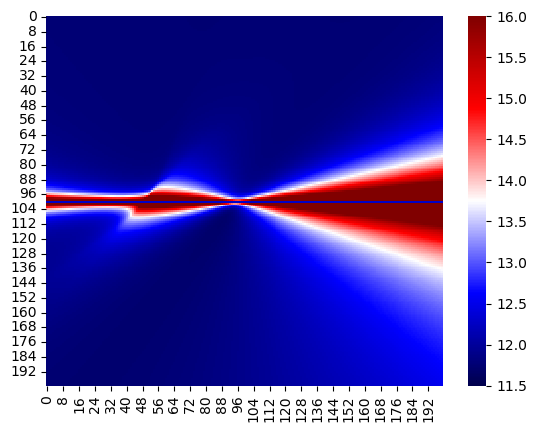

In [36]:
log_proc = np.log2(slice)

sns.heatmap(log_proc, vmin=11.5, vmax=16, cmap="seismic")